In [1]:
import pandas as pd
import numpy as np
import gensim
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

C:\Users\Bowler\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train_orders = pd.read_csv('./order_products__train.csv')
prior_orders = pd.read_csv('./order_products__prior.csv')
products = pd.read_csv('./products.csv').set_index('product_id')

In [3]:
train_orders['product_id'] = train_orders['product_id'].astype(str)
prior_orders['product_id'] = prior_orders['product_id'].astype(str)

In [4]:
train_products = train_orders.groupby('order_id').apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby('order_id').apply(lambda order: order['product_id'].tolist())

In [5]:
sentences = prior_products.append(train_products).values

In [6]:
model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

In [7]:
# Organize data for visualization
vocab = list(model.wv.vocab.keys())
suggestions = model.most_similar(positive=[vocab[1]], topn=5)

C:\Users\Bowler\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

In [9]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    '''From Tensorflow's tutorial.'''
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

C:\Users\Bowler\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
C:\Users\Bowler\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


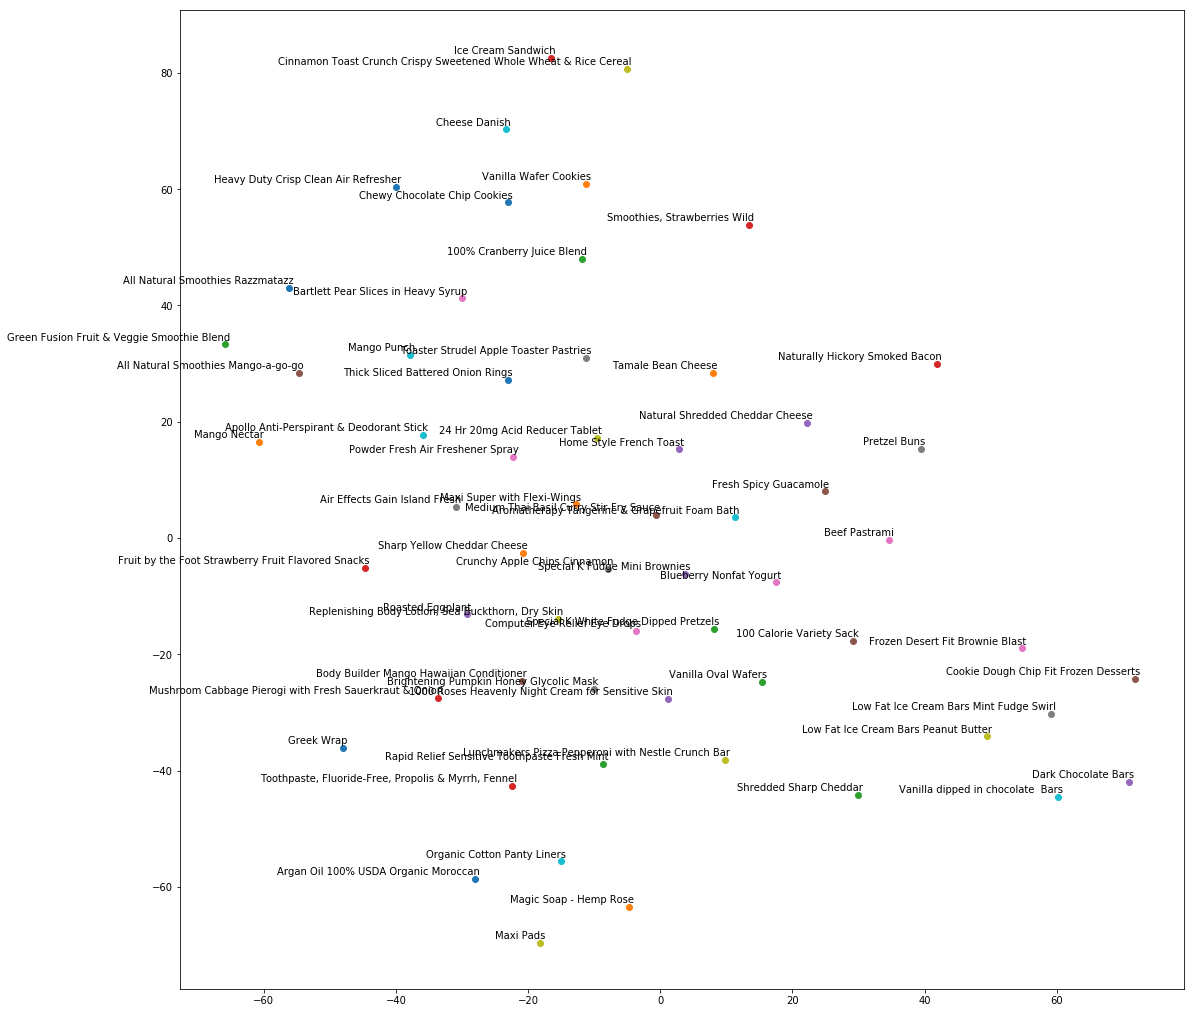

In [10]:
tsne = TSNE()
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=10):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)

embeds = tsne.fit_transform(embeds)
plot_with_labels(embeds, labels)

In [11]:
import sklearn as sk
import pickle

In [12]:
pca = sk.decomposition.PCA(11)
pca.fit(model.wv[vocab])
pca.explained_variance_ratio_
product2vec = pca.transform(model.wv[vocab])
product2vec = pd.DataFrame(product2vec)
product2vec.columns = ['pca_' + str(s) for s in product2vec.columns.tolist()]
product2vec['product_id'] = vocab

In [13]:
product2vec['product_id'] = product2vec['product_id'].astype(int)

In [14]:
pickle.dump(product2vec, open('product2vec.p', 'wb'))

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import utils
import timeit
import pickle
import gc
import time

In [11]:
'''
if __name__ == '__main__':
    # Read data -----------------------------
    aisles, departments, order_prior, order_train, orders, products, product2vec = utils.read_data()

    print('Sample by user_id')
    user_id = orders['user_id'].unique()
    np.random.seed(seed=7)
    sample_user_id = np.random.choice(user_id, size=5000, replace=False).tolist()
    #orders = orders.query('user_id == @sample_user_id')

    def correct_orders(orders):
        orders = orders.copy()
        # Keep users we don't already have
        train_user = orders.query("eval_set == 'train'")['user_id'].unique()
        orders = orders.query('user_id not in @train_user')

        # Keep users with more than 4 orders
        keep_user = orders.groupby('user_id')['order_number'].agg('size').reset_index().query('order_number > 4')['user_id'].unique()
        orders = orders.query('user_id in @keep_user')
        new_orders = orders.query('order_number_reverse !=0')

        df = orders.groupby('user_id')['date'].min().rename('min_date').reset_index()

        new_orders = pd.merge(new_orders, df, on='user_id', how='left')
        new_orders['date'] = new_orders['date'] - new_orders['min_date']
        new_orders = new_orders.drop('min_date', axis=1)

        new_orders['order_number_reverse'] = new_orders['order_number_reverse'] - 1
        cond = new_orders['order_number_reverse'] == 0
        new_orders.loc[cond,'eval_set'] = 'train'
        return new_orders

    orders = correct_orders(orders)

    def correct_order_XXX(orders, order_prior):
        order_train = pd.merge(orders.query("eval_set == 'train'")[['order_id']], order_prior, on='order_id', how='left')
        order_prior = pd.merge(orders.query("eval_set != 'train'")[['order_id']], order_prior, on='order_id', how='left')
        return order_prior, order_train

    order_prior, order_train = correct_order_XXX(orders, order_prior)

    def generate_old_orders(orders, order_prior, order_train):
        ### Feature engineering start here
        print('Add user_id to order_products__XXX ')
        order_prior = pd.merge(orders, order_prior, on=['order_id'])
        order_train = pd.merge(orders, order_train, on=['order_id'])

        print('Add order_size to order_prior')
        order_stat = order_prior.groupby('order_id').agg({'order_id': 'size'}).rename(columns={'order_id': 'order_size'}).reset_index()
        order_prior = pd.merge(order_prior, order_stat, on='order_id')
        order_prior['add_to_cart_order_inverted'] = order_prior.order_size - order_prior.add_to_cart_order
        order_prior['add_to_cart_order_relative'] = order_prior.add_to_cart_order / order_prior.order_size
        del order_stat

        print('Add last_basket_size to orders ')
        last_basket_size = order_prior.groupby(['user_id', 'order_number_reverse']).size().rename('last_basket_size').reset_index()
        last_basket_size['order_number_reverse'] = last_basket_size['order_number_reverse'] - 1

        orders = pd.merge(orders, last_basket_size, how='left', on=['user_id', 'order_number_reverse'])

        del last_basket_size

        ### products_fe - Feature engineering on products
        print('Feature engineering on products')
        # products_fe = utils.get_products_fe(order_prior)

        NFOLD = 5
        products_fe_mod = utils.get_products_fe_mod(order_prior, order_train, nfold=NFOLD)

        # Doesn't seem to help much?
        products_organic = products[['product_id', 'product_name']].copy()
        products_organic['organic_bool'] = products['product_name'].str.match('organic', case=False).astype('int')
        products_fe = pd.merge(products_fe_mod, products_organic.drop('product_name', axis=1), how='left', on='product_id')
        del products_organic

        ### user_fe - Feature engineering on user
        print('Feature engineering on user')
        users_fe = utils.get_users_fe(orders, order_prior)

        ### user_product - UP
        print('Feature engineering on User_product')
        users_products = utils.get_users_products(order_prior)

        ### aisles
        print('Feature engineering on aisles')
        aisles_fe = utils.get_aisles_fe(order_prior, products, aisles)

        ### user_aisle_fe
        print('Feature engineering on user_aisle_fe')
        user_aisle_fe = utils.get_user_aisle_fe(order_prior, products, aisles, users_fe)

        ### departments_fe
        print('Feature engineering on departments')
        departments_fe = utils.get_departments_fe(order_prior, products, aisles, departments)

        ### user_department_fe
        print('Feature engineering on user_department_fe')
        user_department_fe = utils.get_user_department_fe(order_prior, products, aisles, departments, users_fe)

        ### Construct target Y dataset by creating user_past_product
        print('Get label by creating user_past_product')
        # Get for each user all the product he has already bought before
        user_past_product = utils.get_user_past_product(order_prior, orders, order_train)

        print('Get label by creating order_none')
        order_none = utils.get_order_none(order_train)

        # Create dataset which we'll learn on -------------------------------------------------
        print('Create dataset which we will learn on')
        df_full = utils.get_df(orders.query("eval_set == 'train'"), user_past_product, users_fe, products_fe_mod,
                               products, aisles, aisles_fe, departments, departments_fe, users_products,
                               product2vec, user_aisle_fe, user_department_fe, nfold=NFOLD)

        print('Create dataset which we will learn on for None')
        df_full_none = utils.get_df_none(orders.query("eval_set == 'train'"), order_none, users_fe)

        return df_full, df_full_none
'''

'\nif __name__ == \'__main__\':\n    # Read data -----------------------------\n    aisles, departments, order_prior, order_train, orders, products, product2vec = utils.read_data()\n\n    print(\'Sample by user_id\')\n    user_id = orders[\'user_id\'].unique()\n    np.random.seed(seed=7)\n    sample_user_id = np.random.choice(user_id, size=5000, replace=False).tolist()\n    #orders = orders.query(\'user_id == @sample_user_id\')\n\n    def correct_orders(orders):\n        orders = orders.copy()\n        # Keep users we don\'t already have\n        train_user = orders.query("eval_set == \'train\'")[\'user_id\'].unique()\n        orders = orders.query(\'user_id not in @train_user\')\n\n        # Keep users with more than 4 orders\n        keep_user = orders.groupby(\'user_id\')[\'order_number\'].agg(\'size\').reset_index().query(\'order_number > 4\')[\'user_id\'].unique()\n        orders = orders.query(\'user_id in @keep_user\')\n        new_orders = orders.query(\'order_number_reverse !=